# Vectors

We will begin by making an abstract vector class

In [30]:
from abc import ABC, abstractmethod

class vector(ABC):
  """An abstract class for vectors for inverse problems"""
  def __init__(self):
    """Default initializer for an abstract class"""
    pass;

  @abstractmethod
  def get_nd_array(self):
    """Return numpy array representation of the vector"""


  @abstractmethod
  def check_same(self,vec2):
    """Check to see if another vector belongs to the
       same vector space
    """

  @abstractmethod
  def scale(self,sc:float):
    """Scale a vector by another vector"""

  @abstractmethod
  def rand(self):
      """ Filel the vector with random numbers"""
      
  @abstractmethod
  def scale_add(self,vec2,sc1:float=1,sc2:float=1):
    """Scale a vector by another vector, scaling both

        self*sc1+sc2*vec2

        vec2 - Vector to add to the current vector
        sc1 -  How much to scale the current vector by
        sc2 -  How much to scale the vec2 by


    """

  @abstractmethod
  def dot(self,vec2):
    """Calculate the dot product of a vector with the current vector

      vec2 - the vector to dot the current vector with

    """

  @abstractmethod
  def clone(self,spaceOnly=False):
    """Make a copy of the vector

        spaceOnly - Only clone the space

    """



## Now lets make a class which uses numpy arrays as storage

In [40]:
import numpy as np
import copy
class vec_numpy(vector):

  def __init__(self,vals):
    if  isinstance(vals,np.ndarray):
      self._vals=copy.deepcopy(vals)
    if vals is None:
      self._vals=None

  def check_alloc(self,throwError=True):
    """Check to make sure vector is allocated"""
    if self._vals is None:
      if throwError:
        raise Exception("Vector not allocated")
      return False
    return True
  def get_nd_array(self):
    """Return nd_array representation"""
    self.check_alloc()
    return self._vals

  def rand(self):
      """Fill with random numbers"""
      self._vals=np.random.rand(self._vals.shape[0])
  def scale(self,sc:float):
    """Scale a vector by a scalar float"""
    self.check_alloc()
    self._vals*=sc
    return self

  def scale_add(self,vec2,sc1:float=1,sc2:float=1):
    """Scale a vector by another vector, scaling both

        self*sc1+sc2*vec2

        vec2 - Vector to add to the current vector
        sc1 -  How much to scale the current vector by
        sc2 -  How much to scale the vec2 by


    """
    self.check_alloc()
    self._vals=self._vals*sc1+vec2.get_nd_array()*sc2
    return self

  def __str__(self):
    return f"shape={self._vals.shape}\n{self._vals}\n"
  def dot(self,vec2):
    """Calculate the dot product of a vector with the current vector

      vec2 - the vector to dot the current vector with

    """
    self.check_alloc()
    return np.dot(self.get_nd_array(),vec2.get_nd_array())

## Concrete class

Now a concrete class which is a 1-d vector.  We now have defined all
abtract class defined in vector

class vec_1d(vec_numpy):
  def __init__(self,n,o,d,vals=None,spaceOnly=False):
    self._n=n
    self._o=o
    self._d=d
    if self._d==0:
      raise Exception("d can't be 0")
    if vals is not None:
      if not isinstance(vals,np.ndarray):
        raise Exception("Expecting vals to be a numpy array")
      if  vals.dtype != np.float32 and vals.dtype!=np.float64:
        raise Exception(f"Expecting a float array {vals.dtype}")
      if len(vals.shape)!=1:
        raise Exception("Expecting a 1-D array")
      if vals.shape[0]!=self._n:
        raise Exception(f"Expecting the size of arr to be = {n}")
      super().__init__(vals)
    else:
      if spaceOnly:
        super().__init(None)
      else:
        super().__init__(np.zeros((self._n,),dtype=np.float32))


  def check_same(self,vec2):
    if not isinstance(vec2,vec_1d):
      return False
    if vec2._n != self._n:
      return False

    if (self._o-vec2._o)/self._d > .001:
      return False
    if (self._d-vec2._d)/self._d > .001:
      return False
    return True

  def clone(self,spaceOnly=False):
    """Clone a vector, potentionally spaceOnly

      spaceOnly=False

    """
    return vec_1d(self._n,self._o,self._d,self._vals,spaceOnly)



## An abstract operator class 

- Every operator implements a forward and adjoint.
- Knows it domain and range
- Can check to see if the domain and range match what the object initialized

In [42]:
class operator(ABC):
  """An abstract class for operators for inverse problems"""
  def __init__(self,domain,range):
    """Default initializer for an abstract class

      domain - Domain of operator
      range. - Range of operator

    """
    self._domain=domain.clone(spaceOnly=True)
    self._range=range.clone(spaceOnly=True)

  @abstractmethod
  def forward(self,add,model,data):
    """
      Run a forward

      add - Whether or not to add to the output
      model - Model (input)
      data. - Data (output)


    """


  @abstractmethod
  def adjoint(self,add,model,data):
    """
      Run an adjoint

      add - Whether or not to add to the output
      model - Model (output)
      data. - Data (output)


    """

  def check_same(self,model,data):
    """
      Check to see if model and data match operator initialization

        model - Model space
        data. - data space
    """
    if not self._domain.check_same(model):
      raise Exception("model and domain don't match")

    if not self._range.check_same(data):
      raise Exception("range and data don't match")


## Matrix multiply

A class that does matrix multiplication

In [43]:
class matrix_mult(operator):
    """Perform matrix multiplication"""
    def __init__(self,mod,dat,mat):
        """
          Initialize matrix multiplication operator
          mod - Domain
          dat - Range
          mat - Matrix to multiply
    
        """
        if not isinstance(mod,vec_1d):
            raise Exception("Expecting model to be vec_1d")
        if not isinstance(dat,vec_1d):
          raise Exception("Expecting data to be vec_1d")
        if not isinstance(mat,np.ndarray):
          raise Excception("Expecting mat to be a 1-D array")
        if mod._n != mat.shape[1] or dat._n!=mat.shape[0]:
          raise Exception("Matrix doesn't match model and data")
        super().__init__(mod,dat)
        self._mat=copy.deepcopy(mat)

    def forward(self,add,model,data):
        """
          Run a forward
    
          add - Whether or not to add to the output
          model - Model (input)
          data. - Data (output)
    
    
        """
        self.check_same(model,data)
        if not add: data.scale(0.)
    
        d=data.get_nd_array()
        m=model.get_nd_array()
    
        for j in range(d.shape[0]):
          for i in range(m.shape[0]):
            d[j]+=self._mat[j,i]*m[i]

    def adjoint(self,add,model,data):
        """
          Run an adjoint
    
          add - Whether or not to add to the output
          model - Model (output)
          data. - Data (output)
    
    
        """
        self.check_same(model,data)
        if not add: model.scale(0.)
    
        d=data.get_nd_array()
        m=model.get_nd_array()
    
        for j in range(d.shape[0]):
          for i in range(m.shape[0]):
            m[i]+=self._mat[j,i]*d[j]
    


## Test the forward and adjoint

In [44]:
mat=np.array([[1.,2.],[7.,-4.]])
mod=vec_1d(2,0.,1.)
dat=vec_1d(2,0.,1.)
mat_op=matrix_mult(mod,dat,mat)
mod.get_nd_array()[:]=[-2,4]
mat_op.forward(False,mod,dat)
m2=mod.clone()
mat_op.adjoint(False,m2,dat)


In [45]:
print(mod)

shape=(2,)
[-2.  4.]



In [46]:
print(dat)
print(m2)

shape=(2,)
[  6. -30.]

shape=(2,)
[-204.  132.]



## Abstract solver class

The basic iterative solve class

In [ ]:
class solver:
  def __init__(self,lop:operator,m0:vector,d:vector):
    self._lop=lop
    self._m0=m0.clone()
    self._rr=d.clone() # residual

    self._g=self._m0.clone() #gradient vec
    self._gg=self._rr.clone() #gradient mapped back into data space


  def updateModRes(self,mod:vector,res:vector):
    raise Exception("Need to override")

  def steepCalc(self,dir:vector,rr:vector):
    """Direction to seach"""
    self._lop.forward(False,dir,self._gg)
    top=rr.dot(self._gg)
    bot=self._gg.dot(self._gg)
    alpha=-top/(bot+1.e-10)
    return alpha
  
  def iterate(self,niter:int):
    self._rr.scale(-1.) # r=d
    self._lop.forward(True,self._m0,self._rr) #-d+Lm_0
    mod=self._m0.clone()
    mvec=[]
    rvec=[]
    mvec.append(np.copy(mod.get_nd_array()))
    rvec.append(np.copy(self._rr.get_nd_array()))
    for iter in range(niter):
      self.updateModRes(mod,self._rr)
      mvec.append(np.copy(mod.get_nd_array()))
      rvec.append(np.copy(self._rr.get_nd_array()))
    return mvec, rvec

## A concrete class that chooses random directions

In [ ]:
class randomSolver(solver):

  def __init__(self,lop:operator,m0:vector,d:vector):
    super().__init__(lop,m0,d)


  def updateModRes(self,mod,rr):
    self._g.rand()
    alpha=self.steepCalc(self._g,rr)
    mod.scale_add(self._g,sc2=alpha)
    rr.scale_add(self._gg,sc2=alpha)


mat=np.array([[1.,2.],[7.,-4.]])
mod=vec_1d(2,0.,1.)
dat=vec_1d(2,0.,1.)
mat_op=matrix_mult(mod,dat,mat)
mod.get_nd_array()[:]=[-2,4]
mat_op.forward(False,mod,dat)
print(dat.get_nd_array()[:])

## Invert the matrix multiply operator

In [50]:
mod.get_nd_array()[:]=(-199,179)

solve=randomSolver(mat_op,mod,dat)
mvec,rvec=solve.iterate(100)

## A function to print the objective function along with model value over iterate

In [ ]:
import matplotlib.pyplot as plt

def objPlot(oper,mod,mn,mx,npts,col):

  npts=300
  obj=np.zeros((npts,npts))
  test=dat.clone()
  ix=0
  tmp=oper._domain.clone()
  for x in np.linspace(mn,mx,npts):
    iy=0
    for y in np.linspace(mn,mx,npts):
      tmp.get_nd_array()[:]=(y,x)
      oper.forward(False,tmp,test)
      test.scale_add(dat,1,-1)
      obj[ix,iy]=test.dot(test)
      iy+=1
    ix+=1
  plt.figure(figsize=(8,6))
  contours = plt.contour(np.linspace(mn,mx,npts), np.linspace(mn,mx,npts), obj, 10, colors='white')
  plt.clabel(contours, inline=1, fontsize=10)
  plt.imshow(obj[::-1,:],extent=(mn,mx,mn,mx),cmap=plt.cm.hot)
  x=[[v[0]] for v in mod ]
  y=[[v[1]] for v in mod ] 
  plt.plot(x, y, color=col, linewidth=3)

## Plot the result

In [ ]:
objPlot(mat_op,mvec,-500,500,300,"blue")

## Do it again

In [ ]:
mod.scale(0.)
mod.get_nd_array()[:]=(-199,179)
solve=randomSolver(mat_op,mod,dat)

mvec,rvec=solve.iterate(100)
objPlot(mat_op,mvec,-500,500,300,"green")

## Now lets use the adjoint as our search direction

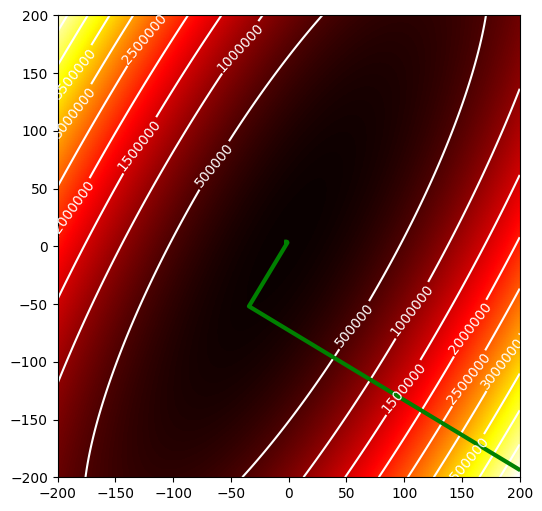

In [73]:
class steepSolver(solver):

  def __init__(self,lop:operator,m0:vec_1d,d:vec_1d):
    super().__init__(lop,m0,d)

  def updateModRes(self,mod,rr):
    self._lop.adjoint(False,self._g,rr)
    alpha=self.steepCalc(self._g,rr)
    mod.scale_add(self._g,sc2=alpha)
    rr.scale_add(self._gg,sc2=alpha)

mod.scale(0.)
mod.get_nd_array()[:]=(199,-193)
solve=steepSolver(mat_op,mod,dat)

mvec,rvec=solve.iterate(50)
objPlot(mat_op,mvec,-200,200,300,"green")

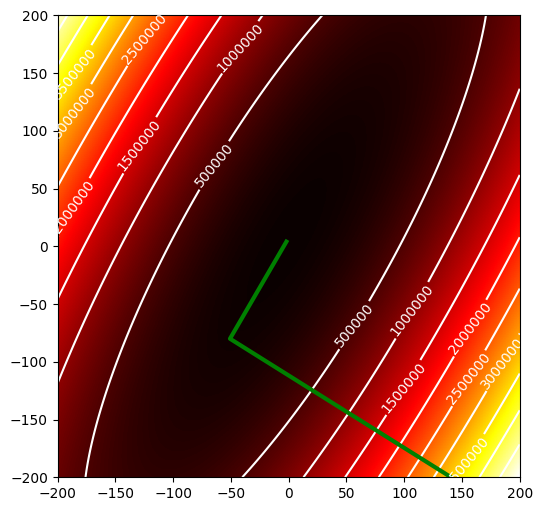

In [77]:
class cgSolver(solver):

  def __init__(self,lop:operator,m0:vector,d:vector):
    super().__init__(lop,m0,d)
    self._s=None
    self._ss=None




  def updateModRes(self,mod,rr):
    
    self._lop.adjoint(False,self._g,rr)

    if self._s is None:
      #Do steepest descent
      self._s=mod.clone()
      self._ss=rr.clone()
      self._s.scale(0.)
      self._ss.scale(0.)
      alpha=self.steepCalc(self._g,rr)
      beta=0.
    else:
      #DO CGSTEP
      self._lop.forward(False,self._g,self._gg)
      g_g=self._gg.dot(self._gg)
      g_s=self._gg.dot(self._ss)
      s_s=self._ss.dot(self._ss)
      if g_g ==0 or s_s==0:
        raise Exception("Solver is stuck")
      determ=g_g*s_s*max(1.-(g_s/g_g)*(g_s/s_s),1.e-12)
      g_r=-self._gg.dot(rr)
      s_r=-rr.dot(self._ss)
      alpha = ( s_s*g_r - g_s*s_r ) / determ 
      beta = (-g_s*g_r + g_g*s_r ) / determ

      
    self._s.scale_add(self._g,sc2=alpha,sc1=beta)
    self._ss.scale_add(self._gg,sc2=alpha,sc1=beta)
    mod.scale_add(self._s) #mod=mod+s
    rr.scale_add(self._ss) #RES=res+ss

mod.scale(0.)
mod.get_nd_array()[:]=(139,-199)
solve=cgSolver(mat_op,mod,dat)
mvec,rvec=solve.iterate(2)

objPlot(mat_op,mvec,-200,200,300,"green")